# Travel Time Prediction Based on Quezon City Traffic Density and Weather Conditions#
#####Newton-Cutes:######
* Constantino, Gabrielle [2019-08424] [THY]
* Floro, Zarah Belle [2020-03245] [THY]
* Gan, Prinz Romeo [2019-07088] [THY]
* Martirez, Derryn Joi [2019-09894] [THY]
* Serrano, Nuan Patricia [2019-03690] [THY]


## 1. Data Collection and Preprocessing

Traffic Data
* from November 26, 2023 to January 13, 2024 (recorded per hour)
* City of Manila
* feature:
1. Live Speed (kilometers/hour)


Weather Data
* from November 26, 2023 to January 13, 2024 (recorded per hour)
* City of Manila
* features:
1. Temperature (temp) (degrees Celsius)
2. Dew Point (dwpt) (degrees Celsius)
3. Relative Humidity (rhum) (percent)
4. Total Precipitation (prcp) (millimeters)
5. Snow Depth (snow)*
6. Wind Direction (wdir) (degrees)*
7. Average Wind Speed (wspd) (kilometers/hour)
8. Wind Peak Gust (wpgt) (kilometers/hour)*
9. Sea-Level Air Pressure (pres) (hectopascal)
10. Total Sunshine Duration (tsun) (minutes)*
11. Weather Condition Code (coco)*


*dropped features

A. Authorize

In [ ]:
from google.colab import auth
import gspread
from google.auth import default
#authenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

B. Retrieve Raw Data

In [ ]:
# Support local but put imports here

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [ ]:
# Retrieving data from gsheets

# Use these variables to update the number of new data and training data
TOTAL_DAYS = 49
TRAINING_DAYS = 40

SHEET_DATA_ROWS = (TOTAL_DAYS * 24) + 1
TRAINING_ROWS = TRAINING_DAYS * 24

wb1 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1OiEW1WU_3_bnIaEewFIQZVgkuGmpTg_i3XFx5_Kwr58/edit?usp=sharing')
sheet1 = wb1.worksheet('138_traffic_data')

data1 = sheet1.get_all_values()[:SHEET_DATA_ROWS]

wb2 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1NJrpnZ1j2BQ7GXziLqW3yiMHOA2aeO_z4bh8K0nGDeY/edit?usp=sharing')
sheet2 = wb2.worksheet('138_weather_data')

data2 = sheet2.get_all_values()[:SHEET_DATA_ROWS]

# Traffic data has been imported from gsheets
df_traffic = pd.DataFrame(data1)
df_traffic.columns = df_traffic.iloc[0]
df_traffic = df_traffic.iloc[1:]

# Weather data has been imported from gsheets
df_weather = pd.DataFrame(data2)
df_weather.columns = df_weather.iloc[0]
df_weather = df_weather.iloc[1:]

# Converting date and time to only the hour
df_traffic['time'] = df_traffic['time'].map(lambda t: int(str(t).split(" ")[1].split(":")[0]))
df_weather['hour'] = df_weather['time'].map(lambda t: int(str(t).split(" ")[1].split(":")[0]))

# Converting other columns to floats
df_traffic = df_traffic.astype({'livespeed' : float})
df_weather = df_weather.astype({'temp' : float, 'dwpt' : float, 'rhum' : float, 'prcp' : float, 'wspd' : float, 'pres' : float})

# Dropping of unecessary columns
df_traffic = df_traffic.drop(["time"], axis = 1)
df_weather = df_weather.drop(["time", "snow", "wdir", "wpgt", "tsun", "coco"], axis = 1)

df_weather.head

<bound method NDFrame.head of 0     temp  dwpt  rhum  prcp  wspd    pres  hour
1     25.1  22.8  87.0   0.0  22.7  1012.5     0
2     24.9  22.6  87.0   0.0  22.7  1011.8     1
3     25.1  22.6  86.0   0.0  23.0  1011.1     2
4     25.1  22.6  86.0   0.0  24.5  1010.7     3
5     25.2  22.5  85.0   0.0  23.8  1010.6     4
...    ...   ...   ...   ...   ...     ...   ...
1172  27.7  19.5  61.0   0.0   9.3  1013.3    19
1173  27.1  19.2  62.0   0.0   7.4  1014.0    20
1174  26.8  19.4  64.0   0.0   7.4  1014.2    21
1175  26.5  19.6  66.0   0.0   5.5  1014.4    22
1176  26.1  19.5  67.0   0.0   5.5  1014.6    23

[1176 rows x 7 columns]>

In [ ]:
# Checking for NULL values
print("Number of Null Values:", df_traffic.isna().sum().sum())
print("Number of Null Values:", df_weather.isna().sum().sum())

Number of Null Values: 0
Number of Null Values: 0


In [ ]:
# Saving original weather for significance analysis later.
df_orig_weather = df_weather.copy()

# Scale weather data to normalize the values
scaler = MinMaxScaler()
df_weather = scaler.fit_transform(df_weather)

# Splitting into 80% training and 20% test sets.
X_train = pd.DataFrame(df_weather).iloc[:TRAINING_ROWS,]
y_train = pd.DataFrame(df_traffic).iloc[:TRAINING_ROWS,]

X_test = pd.DataFrame(df_weather).iloc[TRAINING_ROWS:,]
y_test = pd.DataFrame(df_traffic).iloc[TRAINING_ROWS:,]

C. Plotting the features against live speed

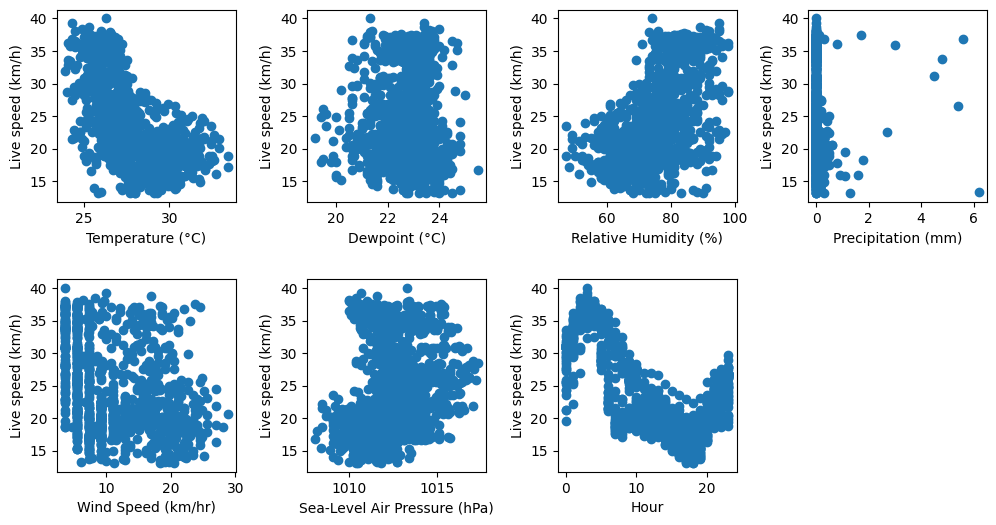

In [ ]:
features = ["Temperature (°C)", "Dewpoint (°C)", "Relative Humidity (%)", "Precipitation (mm)", "Wind Speed (km/hr)", "Sea-Level Air Pressure (hPa)", "Hour"]
# Plotting each feature against live speed (km/h) to see the correlation
fig = plt.figure(figsize = (12, 6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(7):
  ax = fig.add_subplot(2, 4, i + 1)
  ax.scatter(df_orig_weather[df_orig_weather.columns[i]], df_traffic)
  ax.set_xlabel(features[i])
  ax.set_ylabel("Live speed (km/h)")

## 2. Training and Testing the Model

In [ ]:
degrees = list(range(1, 5))
scores = []
scores_test = []

# linear and polynomial regression
for i in degrees:
    regress = PolynomialFeatures(i)

    # transform the training data
    poly_features = regress.fit_transform(X_train)

    # linear regressor
    poly_reg = LinearRegression()

    # fit the polynomial model into the regressor
    poly_reg.fit(poly_features, y_train)

    # predict training data
    y_predicted = poly_reg.predict(poly_features)

    # regression score of the model
    score = poly_reg.score(poly_features, y_train)
    scores.append(score)

    # predict test data
    y_test_predicted = poly_reg.predict(regress.fit_transform(X_test))

    # regression score of the model (test data)
    score_test = poly_reg.score(regress.fit_transform(X_test), y_test)
    scores_test.append(score_test)

    print(i, "degree model ")
    print("Training R2:", score)
    print("Testing R2:", score_test)
    print("RMSE:", mean_squared_error(y_test, y_test_predicted) ** 0.5)
    print("")


1 degree model 
Training R2: 0.6645214284148542
Testing R2: 0.5063973461422476
RMSE: 4.678842094821674

2 degree model 
Training R2: 0.7631380079980539
Testing R2: 0.5577434961439001
RMSE: 4.428807049476733

3 degree model 
Training R2: 0.850103898910991
Testing R2: 0.010075356169452765
RMSE: 6.625989045187333

4 degree model 
Training R2: 0.9107182052238145
Testing R2: -5.173709517307195
RMSE: 16.54713237516209



Based from the scores, the polynomial regression of degree 2 has the best accuracy among the models tested.

## 3. Results

Regression score of Polynomial Regression with degree 2 (Train Data): 0.7631380079980539
Regression score of Polynomial Regression with degree 2 (Test Data): 0.5577434961439001


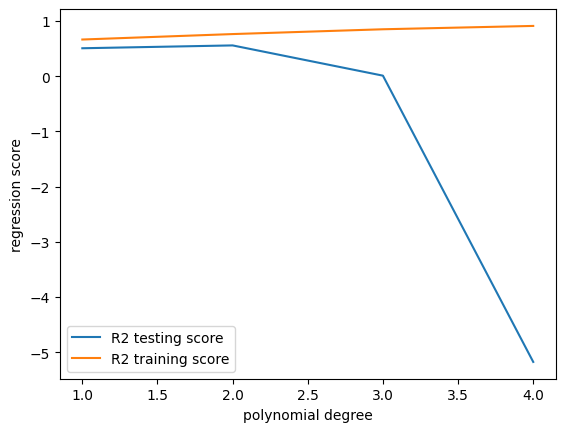

In [ ]:
# plotting each regression score from degree 1 to 4 to see which is the most optimal degree to use
fig, ax = plt.subplots()
plt.plot(degrees, scores_test, label = "R2 testing score")
plt.plot(degrees, scores, label = "R2 training score")
ax.set_xlabel("polynomial degree")
ax.set_ylabel("regression score")
ax.legend()

# choosing degree 2 since it is the most optimal to use
print("Regression score of Polynomial Regression with degree 2 (Train Data):", scores[1])
print("Regression score of Polynomial Regression with degree 2 (Test Data):", scores_test[1])

## 4. Significance Analysis

First, we try and check the accuracy of the model if time was the only feature, to see how significant it is and whether it is enough to predict the traffic density of a place.

In [ ]:
#Checking the significance of the Time feature

#dropped all features except for time
df_time = df_orig_weather['hour']

# splitting the data set into training (80%) and testing (20%) sets
X_train_time = pd.DataFrame(df_time).iloc[:TRAINING_ROWS,]
y_train_time = pd.DataFrame(df_traffic).iloc[:TRAINING_ROWS,]

X_test_time = pd.DataFrame(df_time).iloc[TRAINING_ROWS:,]
y_test_time = pd.DataFrame(df_traffic).iloc[TRAINING_ROWS:,]

#get best fit line and use it to predict live speed
regress = PolynomialFeatures(2)

# transform the training data
poly_features = regress.fit_transform(X_train_time)

# linear regressor
poly_reg = LinearRegression()

# fit the polynomial model into the regressor
poly_reg.fit(poly_features, y_train_time)

# predict training data
y_predicted = poly_reg.predict(poly_features)

# regression score of the model
score = poly_reg.score(poly_features, y_train_time)
scores.append(score)

# predict test data
y_test_predicted = poly_reg.predict(regress.fit_transform(X_test_time))

# regression score of the model (test data)
time_score = poly_reg.score(regress.fit_transform(X_test_time), y_test_time)

print("R2 score of model with time:", time_score)


R2 score of model with time: 0.6218086472708723


As we can see here, if we only use time to predict live speed the accuracy is at 62.18% which is higher than when the weather features are included in the model. Hence, we see that time has a significant effect in predicting live speed. While the weather features not so much.

We can also try changing the values of each attribute in the weather dataframe by incrementing it by 5% up to 30% to see if they significantly affect the linear prediction model.

In [ ]:
for i in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
  for attr in ['temp', 'dwpt', 'rhum', 'prcp', 'wspd', 'pres']:
    df_weather_sig = df_orig_weather.copy()
    df_weather_sig[attr] = df_weather_sig[attr].map(lambda t: t + (t * i))

    X_train_sig = pd.DataFrame(df_weather_sig).iloc[:TRAINING_ROWS,]
    y_train_sig = pd.DataFrame(df_traffic).iloc[:TRAINING_ROWS,]

    X_test_sig = pd.DataFrame(df_weather_sig).iloc[TRAINING_ROWS:,]
    y_test_sig = pd.DataFrame(df_traffic).iloc[TRAINING_ROWS:,]

    #get best fit line and use it to predict live speed
    regress = PolynomialFeatures(2)

    # transform the training data
    poly_features = regress.fit_transform(X_train_sig)

    # linear regressor
    poly_reg = LinearRegression()

    # fit the polynomial model into the regressor
    poly_reg.fit(poly_features, y_train_sig)

    # predict training data
    y_predicted = poly_reg.predict(poly_features)

    # regression score of the model
    score = poly_reg.score(poly_features, y_train_sig)
    scores.append(score)

    # predict test data
    y_test_predicted = poly_reg.predict(regress.fit_transform(X_test_sig))

    # regression score of the model (test data)
    sig_score = poly_reg.score(regress.fit_transform(X_test_sig), y_test_sig)

    print("R2 score of linear model:", sig_score, "Percentage:", i, "Altered attribute: ", attr)
  print("\n")

R2 score of linear model: 0.557743495931723 Percentage: 0.05 Altered attribute:  temp
R2 score of linear model: 0.5577434959640819 Percentage: 0.05 Altered attribute:  dwpt
R2 score of linear model: 0.5577434957416614 Percentage: 0.05 Altered attribute:  rhum
R2 score of linear model: 0.5577434965880195 Percentage: 0.05 Altered attribute:  prcp
R2 score of linear model: 0.5577434964170989 Percentage: 0.05 Altered attribute:  wspd
R2 score of linear model: 0.5577434959290986 Percentage: 0.05 Altered attribute:  pres


R2 score of linear model: 0.5577434960623371 Percentage: 0.1 Altered attribute:  temp
R2 score of linear model: 0.5577434962542067 Percentage: 0.1 Altered attribute:  dwpt
R2 score of linear model: 0.5577434958115174 Percentage: 0.1 Altered attribute:  rhum
R2 score of linear model: 0.5577434963664685 Percentage: 0.1 Altered attribute:  prcp
R2 score of linear model: 0.5577434962563417 Percentage: 0.1 Altered attribute:  wspd
R2 score of linear model: 0.5577434959808814 Pe

In increasing the attributes of temperature, dewpoint, humidity, precipitation, windspeed, and sea pressure, there is not significant changes to the prediction success rate of the model. Hence, there can be no isolated attribute which can significantly affect the outcome of the prediction.